#Setup 

Descargamos es_core_news_md de spacy para tener un vocabulario en español para la etapa de embeddings

In [ ]:
!python -m spacy download es_core_news_md > a

     |████████████████████████████████| 78.4 MB 1.3 MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-py3-none-any.whl size=79649483 sha256=fda048f7925f139c871975665b0d73820d6d8d5ebe0b2b30a2ff436a77fe1e9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mrhfijdy/wheels/d8/f5/92/ee8a4f74fac67775fbc0314b1c9ae4694f4180437f6fc3dd1c
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


Cargamos es_core_news_md .

En colab suele tener un error la siguiente linea. Si aparece un error de es_core_news_md, reiniciar el entorno de ejecucion y correr nuevamente las celdas, evitando correr la la linea: 


`!python -m spacy download es_core_news_md > a
`

In [2]:
import spacy
nlp = spacy.load("es_core_news_md")

In [3]:
import pandas as pd
# Seteamos en False para no mostrar todas las columnas cuando veamos los vectores
pd.set_option("display.max_columns", False)

In [4]:
from statistics import pstdev
from random import randint
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

Conectar con la cuenta de Google Drive, se espera que en una carpeta llamada Mineria se encuentren guardados los dataframes creados en Parseo.ipynb

In [5]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Mineria/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los dataframes creados en Parseo.ipynb

In [6]:
training_df = pd.read_csv(drive_path+'training_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
develop_df = pd.read_csv(drive_path+'develop_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
test_df = pd.read_csv(drive_path+'test_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })

training_0_df = pd.read_csv(drive_path+'training_0_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
training_1_df = pd.read_csv(drive_path+'training_1_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
training_extra_df = pd.read_csv(drive_path+'training_extra_df.csv', dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })

Los tweets tienen un atributo class, el cual es una division que nos sirve para determinar la cantidad de respuestas que tiene

In [7]:
training_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class
0,0,Sat Mar 13 03:56:36 +0000 2021,1370584553845366788,"Mi mamá en Río Grande, clavó la Sputnik V y le...",1370344483796189184,367933714,34724559,0
1,1,Fri Mar 05 01:17:47 +0000 2021,1367645483334787073,Que mal que Argentina no este y en su lugar es...,1367604623788429314,252168075,603932718,1
2,0,Tue Jan 19 13:22:13 +0000 2021,1351520337016578048,Cuando gobiernan Ellos es El Todo Pasa de Gron...,1351519522411458560,252168075,358378950,0
3,1,Fri Mar 19 18:42:15 +0000 2021,1372981763753005061,Ay..ojalá!!!!,1372967749983596545,747576601819385857,147445752,1
4,0,Tue Feb 02 19:56:41 +0000 2021,1356693040463826953,"Con controlar ezeiza era el 50 % del laburo,si...",1356691940423708673,4843819715,2301867769,0
...,...,...,...,...,...,...,...,...
130461,0,Fri Jan 29 23:23:22 +0000 2021,1355295500782735360,La ideologización y la obsecuencia rompen todo,1355295097940803593,252168075,153866271,0
130462,0,Fri Feb 12 12:05:45 +0000 2021,1360198403662237696,¿Descontaron o estan contadas como muertes x c...,1359667090282713090,73102744,1034564064658313217,0
130463,3,Wed Jan 20 22:59:59 +0000 2021,1352028124981178370,Hoy comenzó la vacunación con el segundo compo...,NaN,NaN,349923903,3
130464,0,Thu Jan 14 15:03:57 +0000 2021,1349733999850135554,1. Michael\n2. Homero se vuelve inteligente y ...,1349513197775155203,593189095,151576418,0


# Funciones auxiliares (Y no tan auxiliares)

In [8]:
#devuelve un arreglo del texto como string
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

def get_text_array(df):
  return df['full_text'].values.astype('str')

def get_class_array(df):
  return df['class'].to_numpy()

Conseguimos el vocabulario para los vectores de Coountvectorizer, usando todos los tweets

In [9]:
def get_training_vocab():
  training_df = pd.read_csv(drive_path+"training_df.csv", dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
  training_array = get_text_array(training_df)
  cv_tr = CountVectorizer(lowercase=True, min_df=2, max_features=15000)
  cv_t = cv_tr.fit_transform(training_array)
  return cv_tr.vocabulary_

countvec_vocabulary = get_training_vocab()

Conseguir los vectores de palabras para countvectorizer

In [10]:
# /usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
#   warnings.warn(msg, category=FutureWarning)

def get_vectors_dataframe(training_array,  vocab=countvec_vocabulary):
  coun_vect = CountVectorizer(vocabulary = vocab)
  count_matrix = coun_vect.fit_transform(training_array)
  count_array = count_matrix.toarray()
  vectors_dataframe = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out()) 
  return vectors_dataframe

Entrenar la regression logistica. 

Se puede agregar el parametro max_iter, que viene por defecto con 100, para que el entrenamiento tenga un mejor resultado, pero hay que tener en cuenta que eso generaria un aumento del tiempo de ejecucion.

Cuando usamos el valor por defecto, muchas veces aparece el warning `ConvergenceWarning`, pero la ejecucion sigue sin problemas.

In [11]:
#https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/Logistic_Regression/LogisticRegression_toy_digits_Codementor.ipynb
#https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

from sklearn.linear_model import LogisticRegression

def train_logistic_regression(vectors_training_df, training_classes):
  logisticRegr = LogisticRegression()#max_iter=200
  logisticRegr.fit(vectors_training_df, training_classes)
  return logisticRegr

# Matriz de confusion




Visualizar que label toco y cual deberia haber tocado.

In [12]:
def plt_confusion_matrix(Logistic_Regression, vectors_develop, develop_tags, score, title, classes=["0","1","2","+3"]):

  predictions_tags = Logistic_Regression.predict(vectors_develop) 

  confusion_matrix = metrics.confusion_matrix(develop_tags, predictions_tags)
  plt.figure(figsize=(12,12))
  sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, square = True, robust=True, cmap = 'YlGnBu', cbar=False);
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  plt.yticks(plt.yticks()[0], labels=classes, rotation=0)
  plt.xticks(plt.xticks()[0], labels=classes)
  plt_title = f'{title} - Accuracy Score: {round(score,3)}'
  plt.title(plt_title, size = 15);
  plt.savefig(drive_path+f'Confusion_matrix/{title}.png')
  plt.show();

# Primera aproximacion con Bag of Words

In [13]:
# preparar el vector de develop para testear los resultados
develop_class = get_class_array(develop_df)
develop_array = get_text_array(develop_df)
vectors_develop_df = get_vectors_dataframe(develop_array)

Asi se ve un vector de BOW

In [14]:
vectors_develop_df

,00,000,01,02,03,04,05,050,06,07,08,0800,09,10,100,1000,10000,100000,100mil,101,102,104,105,107,10m,10mil,10mo,11,110,112,113,116,12,120,1200,12000,122,125,13,130,...,ésta,éstas,éste,ésto,éstos,ética,éticamente,ético,éticos,éxito,éxitos,íbamos,ídem,ídolo,ídolos,índice,índices,ña,ñañaña,ñañañaña,ñoqui,ñoquis,ñora,óptimo,órdenes,órgano,ósea,última,últimamente,últimas,último,últimos,única,únicamente,únicas,único,únicos,útero,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#reducimos la cantidad de tuits porque la RAM no soporta todos para el entrenamiento
training_array = get_text_array(training_df)[:25000]
training_class = training_df['class'].to_numpy()[:25000]

vectors_training_df = get_vectors_dataframe(training_array)

logisticRegr = train_logistic_regression(vectors_training_df, training_class)

score = logisticRegr.score(vectors_develop_df, develop_class)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

En esta primera iteracion, como la clase del 0 tiene muchos mas elementos de entrenamiento, las predicciones tienden a llevar a la mayoria de tweets a esa clase.

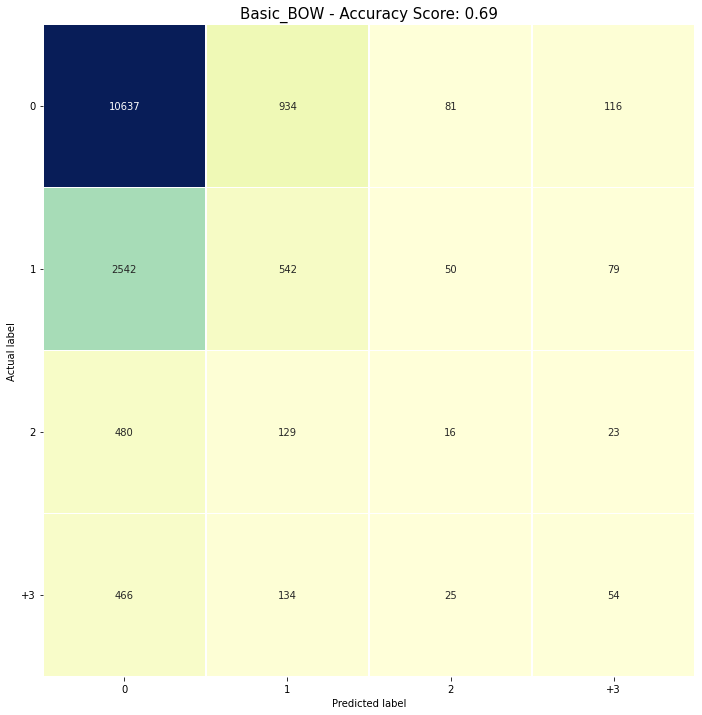

In [16]:
plt_confusion_matrix(logisticRegr, vectors_develop_df, develop_class, score, "Basic_BOW")

#BOW con clase del 0 y 1 divididas


Para que la prediccion no se base en la cantidad de elementos, si no que se concentre en realmente el contenido del tweet, separamos la clase del 0 y del 1 en otros nuevos dataframes, los cuales estan marcados con subgrupos para ser entrenados por separado y tomar el promedio entre los resultados.

In [17]:
training_0_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class,subgrupo
0,0,Sat Mar 13 03:56:36 +0000 2021,1370584553845366788,"Mi mamá en Río Grande, clavó la Sputnik V y le...",1370344483796189184,367933714,34724559,0,4
1,0,Tue Jan 19 13:22:13 +0000 2021,1351520337016578048,Cuando gobiernan Ellos es El Todo Pasa de Gron...,1351519522411458560,252168075,358378950,0,18
2,0,Tue Feb 02 19:56:41 +0000 2021,1356693040463826953,"Con controlar ezeiza era el 50 % del laburo,si...",1356691940423708673,4843819715,2301867769,0,1
3,0,Fri Mar 05 11:13:05 +0000 2021,1367795295946485763,Mejor! Tenemos n sistema inmunológico que no n...,1367606349513830401,252168075,869693162016694272,0,12
4,0,Mon Feb 22 18:40:43 +0000 2021,1363921679278362626,Pero como dos semanas? Si Valdez y taiana se v...,1363642642706358278,367933714,1309174618863874048,0,6
...,...,...,...,...,...,...,...,...,...
93753,0,Wed Feb 24 00:05:41 +0000 2021,1364365849780436993,"Eso si no es funcionario público, en cuyo caso...",1363829041367822338,1571834425,1299779790266863617,0,3
93754,0,Sat Feb 20 21:08:32 +0000 2021,1363234105115041792,"@senior_enduto, no te pongas a la defensiva as...",1363231962505375747,2831912244,1236566016,0,12
93755,0,Fri Jan 29 23:23:22 +0000 2021,1355295500782735360,La ideologización y la obsecuencia rompen todo,1355295097940803593,252168075,153866271,0,5
93756,0,Fri Feb 12 12:05:45 +0000 2021,1360198403662237696,¿Descontaron o estan contadas como muertes x c...,1359667090282713090,73102744,1034564064658313217,0,13


Teniendo los tweets con 0 y 1 respuestas separados y marcados con sus subgrupos para ser divididos nuevamente, se va a utilizar la funcion join_dataframes que toma como input los dataframes de tuits con 0,con 1 y con 2 y +3 respuestas y los une mediante dos indices que indicaran que subgrupo de los df de 0 y 1 respuestas elegir. Para elegir estos indices, simplemente se van a tomar todas las combinaciones, en un loop anidado.


In [18]:
def join_dataframes(training_0, training_1, training_extra, idx_0, idx_1):
  training_0_df  = training_0.loc[training_0['subgrupo'] == idx_0]
  training_1_df  = training_1.loc[training_1['subgrupo'] == idx_1]
  training_dataframe = pd.concat([training_0_df, training_1_df, training_extra], ignore_index=True)
  training_dataframe = training_dataframe.drop(columns=['subgrupo'])
  return training_dataframe

Funcion para entrenar con logistic regression, para los dataframes divididos en clases.

In [19]:
def get_LogisticRegr_subset(idx_0, idx_1, training_0_df=training_0_df, training_1_df=training_1_df, training_extra_df=training_extra_df):
  training_dataframe = join_dataframes(training_0_df, training_1_df, training_extra_df, idx_0, idx_1)
  training_class = training_dataframe['class'].to_numpy()
  vectors_training_df = get_vectors_dataframe(get_text_array(training_dataframe))
  logisticRegr = train_logistic_regression(vectors_training_df, training_class)
  return logisticRegr

In [20]:
scores = []

idx_1 = 1
idx_0_random = randint(1,18)

for idx_0 in range(1,19):
  logisticRegr =get_LogisticRegr_subset(idx_0, 1)
  score = logisticRegr.score(vectors_develop_df, develop_class)
  scores.append(score)
  if idx_0_random == idx_0:
    saved_for_plot_emb = (logisticRegr, score, idx_0, idx_1)  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

In [21]:
print(scores)

[0.4519867549668874]


La de arriba fue la ejecucion de todos los subgrupos de la clase del 0, con el primer subgrupo de la clase del 1, ejecutar esto lleva mucho tiempo. Por esto, se corrieron las demas clases del 1 en otros notebooks, cambiando en la linea


```
idx_1 = 1
```
el 1  por los siguientes numeros hasta el 5 (`idx_1 = 2`, `idx_1 = 3`, etc),  para tomar las 5 clases.
Aqui los resultados:

In [22]:
class1 = [0.4519867549668874, 0.4404586705911209, 0.4541942604856512, 0.44885945548197204, 0.4527225901398087, 0.44990188864361047, 0.4527225901398087, 0.4448123620309051, 0.45719892077507973, 0.45578857002698064, 0.44499632082413537, 0.4515575177826833, 0.44622271277900416, 0.4625337257787589, 0.44542555800833944, 0.45204807456463086, 0.44984056904586706, 0.4491660534706892]
class2 = [0.43941623742948244, 0.4455481972038263, 0.44401520726024035, 0.4386804022565612, 0.4440765268579838, 0.4334682364483689, 0.4400907530046603, 0.4331616384596517, 0.4448123620309051, 0.44383124846701005, 0.44873681628648515, 0.4480623007113073, 0.44291145450085845, 0.4506377238165318, 0.437392690703949, 0.44885945548197204, 0.4419916605347069, 0.44272749570762815]
class3 = [0.44125582536178565, 0.4371474123129752, 0.4347559480009811, 0.4467132695609517, 0.4494726514594064, 0.4430954132940888, 0.4543168996811381, 0.4440765268579838, 0.4545008584743684, 0.43923227863625214, 0.45112828059847926, 0.45229335295560463, 0.44732646553838606, 0.46057149865096886, 0.44542555800833944, 0.4411945057640422, 0.45830267353446164, 0.45229335295560463]
class4 = [0.45217071376011775, 0.45867059112092223, 0.4484915378955114, 0.4467745891586951, 0.44150110375275936, 0.43910963944076525, 0.45364238410596025, 0.44291145450085845, 0.44867549668874174, 0.4508216826097621, 0.4491047338729458, 0.4408265881775816, 0.4530905077262693, 0.45345842531272995, 0.44763306352710325, 0.45437821927888156, 0.4483075791022811, 0.44628403237674763]
class5 = [0.45462349766985527, 0.4541329408879078, 0.45125091979396614, 0.44524159921510914, 0.4461000735835173, 0.44291145450085845, 0.44646799116997793, 0.4441991660534707, 0.4543168996811381, 0.44475104243316166, 0.4554819720382634, 0.4491047338729458, 0.4492273730684327, 0.46057149865096886, 0.4527225901398087, 0.4481849399067942, 0.4505764042187883, 0.44585479519254356]

classes_perc_bow = class1+class2+class2+class4+class5

In [23]:
print("promedio:           " ,round(sum(classes_perc_bow)/len(classes_perc_bow),4))
print("desviacion estandar:" ,round(pstdev(classes_perc_bow),4))

promedio:            0.4469
desviacion estandar: 0.006


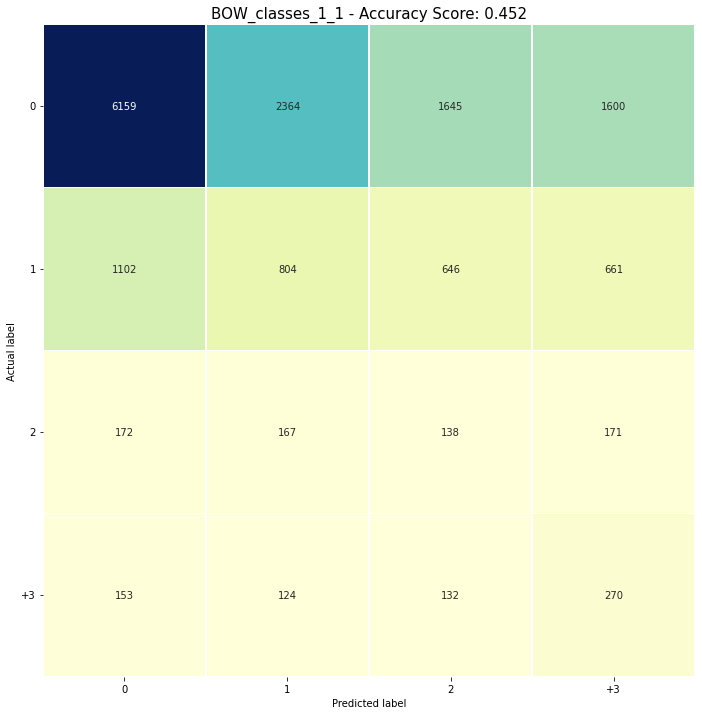

In [24]:
plt_confusion_matrix(saved_for_plot_emb[0], vectors_develop_df, develop_class, saved_for_plot_emb[1], f"BOW_classes_{saved_for_plot_emb[2]}_{saved_for_plot_emb[3]}")

# BOW Discreto

Para analizar un poco mejor las cantidades de respuestas, sin depender de las clases que asignamos, se va a hacer un analisis tomando como las clases los primeros 20 enteros.

In [25]:
def get_tweets_class_discrete(dataframe):
  tweets_class = []
  for idx,data in dataframe.iterrows():
      class_tw = 0
      n_ans = data["ans"]
      if n_ans>=int(20):class_tw=20
      else:class_tw = n_ans
      tweets_class.append(class_tw)
  return tweets_class

In [26]:
def get_LogisticRegr_subset_discrete(idx_0, idx_1, training_0_df=training_0_df, training_1_df=training_1_df, training_extra_df=training_extra_df):
  training_dataframe = join_dataframes(training_0_df, training_1_df, training_extra_df, idx_0, idx_1)

  training_class = get_tweets_class_discrete(training_dataframe)

  vectors_training_df = get_vectors_dataframe(get_text_array(training_dataframe))
  logisticRegr = train_logistic_regression(vectors_training_df, training_class)

  return logisticRegr


In [27]:
develop_class_disc_bow = get_tweets_class_discrete(develop_df)

----------------------- 
PONER LA CANTIDAD DE ELEMENTOS POR CLASE, para ver como es la distribucion, y ver asi como en la matriz de confusion depende de la cantidad de elementos.
----------------------

Igual que en el metodo anterior, para no consumir memoria solo se corre en este notebook el loop de la clase del 0 con una sola clase del 1.

In [28]:
scores = []
idx_1 = 1
idx_0_random = randint(1,18)

for idx_0 in range(1,19):
  logisticRegr = get_LogisticRegr_subset_discrete(idx_0, idx_1)
  score = logisticRegr.score(vectors_develop_df, develop_class_disc_bow)
  scores.append(score)
  if idx_0_random == idx_0:
    saved_for_plot_emb = (logisticRegr, score, idx_0, idx_1)  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

In [29]:
print(scores)

[0.46388275692911457]


In [30]:
class_1_bow_disc = [0.46388275692911457, 0.45486877606082904, 0.46216580819229824, 0.46927888153053715, 0.46805248957566836, 0.45818003433897475, 0.47541084130488104, 0.4587319107186657, 0.46768457198920776, 0.46792985038018153, 0.49294824625950456, 0.47657591366200636, 0.4622271277900417, 0.464925190090753, 0.4637601177336277, 0.4673166544027471, 0.4735712533725779, 0.4630242825607064]
class_2_bow_disc = [0.4608167770419426, 0.46192052980132453, 0.45916114790286977, 0.4675006131959774, 0.4675619327937209, 0.4409492273730684, 0.4625950453765023, 0.45088300220750555, 0.4697694383124847, 0.47633063527103264, 0.46437331371106205, 0.4589771891096394, 0.4666421388275693, 0.49080206033848417, 0.4577507971547707, 0.4682364483688987, 0.4666421388275693, 0.4635148393426539]
class_3_bow_disc = [0.46204316899681136, 0.45977434388030414, 0.4649865096884964, 0.46915624233505027, 0.47387785136129507, 0.4675619327937209, 0.46958547951925433, 0.46425067451557517, 0.46921756193279374, 0.4698920775079716, 0.4698307579102281, 0.4603262202599951, 0.4682364483688987, 0.4711797890605838, 0.4700147167034584, 0.4405813097866078, 0.460448859455482, 0.4722222222222222]
class_4_bow_disc = [0.45437821927888156, 0.45867059112092223, 0.47007603630120187, 0.4636987981358842, 0.4601422614667648, 0.4503311258278146, 0.4673779740004906, 0.4613073338238901, 0.4688496443463331, 0.4630242825607064, 0.4708731910718666, 0.4541942604856512, 0.4649865096884964, 0.4805616875153299, 0.4648025508952661, 0.4715477066470444, 0.4732646553838607, 0.4575055187637969]
class_5_bow_disc = [0.4624724061810154, 0.46829776796664213, 0.47651459406426294, 0.47498160412067697, 0.4636374785381408, 0.48853323522197695, 0.47430708854549913, 0.4590998283051263, 0.4651704684817268, 0.47418444935001225, 0.4718543046357616, 0.4586092715231788, 0.4685430463576159, 0.48350502820701496, 0.47498160412067697, 0.47921265636497423, 0.47559480009811134, 0.4611846946284032]

classes_perc_bow_disc = class_1_bow_disc+class_2_bow_disc+class_2_bow_disc+class_4_bow_disc+class_5_bow_disc

In [31]:
print("promedio:           " ,round(sum(classes_perc_bow_disc)/len(classes_perc_bow_disc),4))
print("desviacion estandar:" ,round(pstdev(classes_perc_bow_disc),4))

promedio:            0.4662
desviacion estandar: 0.0092


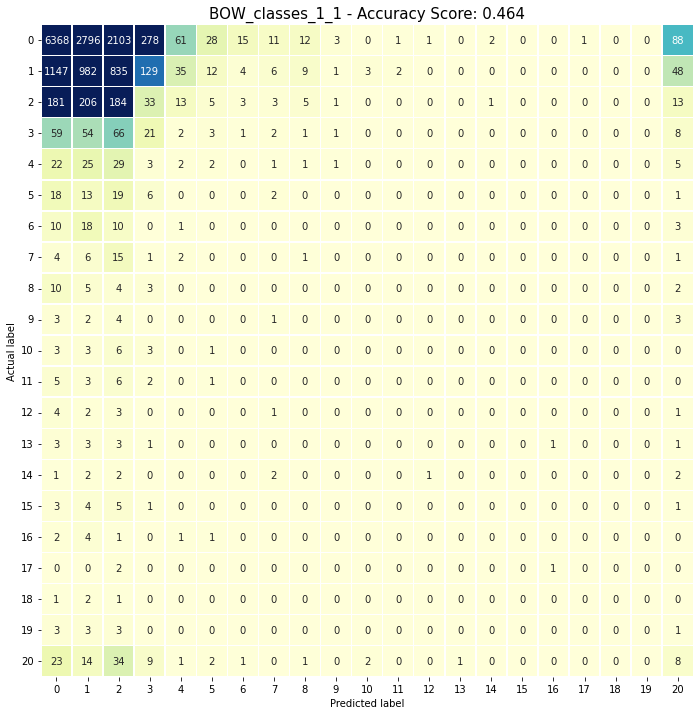

In [32]:
discrete_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt_confusion_matrix(saved_for_plot_emb[0], vectors_develop_df, develop_class_disc_bow, saved_for_plot_emb[1], f"BOW_classes_{saved_for_plot_emb[2]}_{saved_for_plot_emb[3]}", classes=discrete_classes)

# Embeddings


##Primera aproximacion con embeddings

Tomando como base el trabajo de Nazareno ........

In [33]:
from gensim.models import KeyedVectors

f = f"drive/MyDrive/Mineria/fasttext_spanish_twitter_100d.vec"
wordvectors = KeyedVectors.load_word2vec_format(f)

In [34]:
import re
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def filter_token(token):
    """
    Funcion para filtrar los tokens que no son interesantes. No usa las stopwords.
    """
    return token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    """
    Funcion para pasar de una lista de palabras (ya procesadas preferentemente)
    a texto
    """
    text = ""
    for word in list_words:
        text = text + " " + word
    text = re.sub('['+ punctuation + ']+', ' ', text)
    text = re.sub('([0-9]+)', '', text)             
    return text

def clean_tweets(corpus=training_df):
    """
    Funcion para filtrar las palabras de los tweets luego de procesarlas con 
    #######Spacy y con pysentimento.
    Devuelve un diccionario que le asignan un unico ID a cada tweet.
    """
    data = {}
    wv_data = {}
    for position, b in corpus.iterrows():
        tweet = b['full_text']
        if (isinstance(b['full_text'], float)): continue
        doc = nlp(tweet.strip())
        list_words = []
        vector_value = np.array([0 for i in range(100)], dtype=np.float64)
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
            if not (token.text.lower() in wordvectors.vocab): continue
            vector_value += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
        
        data[position] = {"tweet": convert_listwords(list_words), "wv_vector": vector_value}

    return data 

--------------------------------
PONER EN EL README ALGUN WARNING DE QUE LOS PICKLE OCUPAN MUCHA MEMORIA (3 GB SI GUARDAS LOS 90 + EL TRAINING)

Se puede directamente cargar si ya tenias hecho!

La primera ejecucion va a saltar la exception y guardar el archivo en drive,
en las proximas se va a cargar desde drive.

- Importante: si se cambian cosas en la data, habria que borrar el archivo de drive.

In [35]:
def get_vectors_matrix(dataframe, title="data_tweets_emb"):
  try:
    with open(f"{drive_path}{title}.pkl", 'rb') as f:
        data = pickle.load(f)
  except Exception as e:
    data = clean_tweets(dataframe)
    data_file = open(f"{drive_path}{title}.pkl", "wb")
    pickle.dump(data, data_file)
  finally:
    wv_vectors = [data[i]['wv_vector'] for i in data]
    wv_X = np.asarray(wv_vectors)
  return wv_X

In [36]:
wv_X = get_vectors_matrix(training_df, "data_tweets_emb")

Asi se ve un vector usando embeddings

In [37]:
wv_X

array([[-1.68846703,  0.18453314,  4.70874299, ...,  1.78688998,
         4.84529296,  0.697263  ],
       [ 0.47083601, -2.87857801,  4.39552601, ...,  1.96682702,
         3.07951697, -0.6027816 ],
       [ 3.41616199, -0.284175  ,  8.17240346, ...,  4.4070626 ,
         3.62385218, -2.69215727],
       ...,
       [ 0.43866353, -1.99208505, 14.11377303, ...,  3.4843958 ,
         7.55583   ,  0.6112683 ],
       [ 2.22613762, -7.56618027, 13.26332524, ..., -4.65255404,
         9.60682909,  4.13116055],
       [ 0.75810003, -1.02716   ,  2.16582998, ...,  1.02337102,
         0.61978899,  0.115899  ]])

In [38]:
# Ahora usamos este metodo en vez de:
# training_class = training_df['class'].to_numpy()
# para ver las clases de los tuits que si usamos, porque los tuits sin texto no los guardamos en data
def get_tweets_class(dataframe):
  tweets_class = []
  for idx,data in dataframe.iterrows():
      if (isinstance(data['full_text'], float)): continue
      tweets_class.append(data["class"])
  return tweets_class

In [39]:
training_class_clean = get_tweets_class(training_df)

In [40]:
logisticRegr = train_logistic_regression(wv_X, training_class_clean)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [41]:
wv_X_dev = get_vectors_matrix(develop_df, "data_embeddings/data_tweets_emb_develop")
develop_class_clean = get_tweets_class(develop_df)
score_emb = logisticRegr.score(wv_X_dev, develop_class_clean)

----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

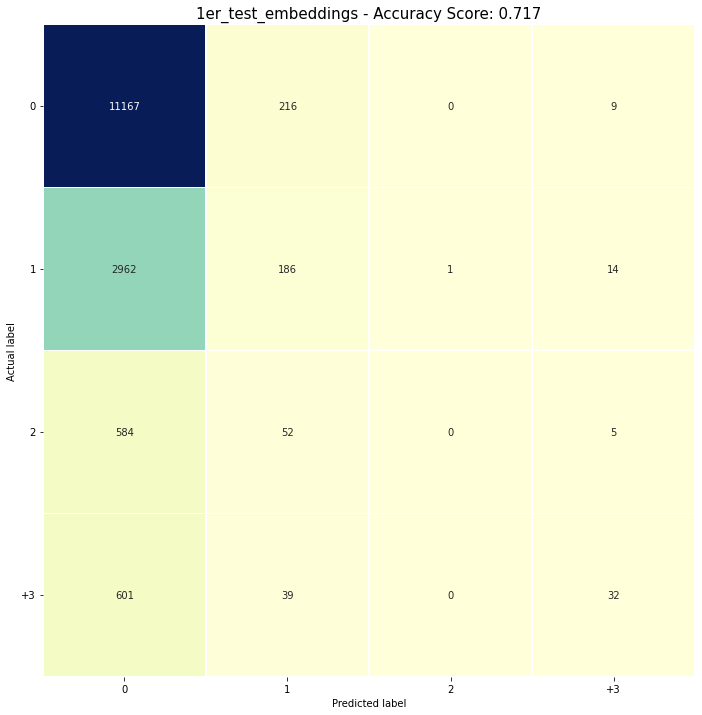

In [42]:
plt_confusion_matrix(logisticRegr, wv_X_dev, develop_class_clean, score_emb, "1er_test_embeddings")

# Embeddings con clases


Ahora vamos a tomar los vectores con embeddings, pero con las divisiones en subgrupos de las clases del 0 y el 1, para que no haya sezgo de la cantidad de elementos en las clases.

In [43]:
def get_LogisticRegr_subset_embeddings(idx_0, idx_1, training_0_df=training_0_df, training_1_df=training_1_df, training_extra_df=training_extra_df):
  training_dataframe = join_dataframes(training_0_df, training_1_df, training_extra_df, idx_0, idx_1)

  training_class = get_tweets_class(training_dataframe)

  wv_X = get_vectors_matrix(training_dataframe, f"data_embeddings/data_tweets_emb_{idx_0}_{idx_1}")

  logisticRegr = train_logistic_regression(wv_X, training_class)
  return logisticRegr

Otra vez, solo corremos el primer subgrupo de la clase de 1 respuesta, para ahorrar tiempo de ejecucion


In [44]:
scores = []
idx_0_random = randint(1,18)
idx_1 = 1

for idx_0 in range(1,19):
  logisticRegr = get_LogisticRegr_subset_embeddings(idx_0, idx_1)
  score = logisticRegr.score(wv_X_dev, develop_class_clean)
  scores.append(score)
  if idx_0_random == idx_0:
    saved_for_plot_emb = (logisticRegr, score, idx_0, idx_1)   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

In [45]:
print(scores)

[0.5139274010587346]


In [46]:
class_1_emb = [0.5139274010587346, 0.52268716914545, 0.5224981094025712, 0.5224350894882783, 0.5229392488026217, 0.5221830098311067, 0.5242626670027729, 0.5103352659440383, 0.5122888832871187, 0.5228132089740358, 0.524955886059995, 0.5223090496596925, 0.517393496344845, 0.5170153768590875, 0.5257751449458029, 0.5149987396017142, 0.5291152004033275, 0.5182757751449458]
class_2_emb = [0.5122888832871187, 0.5185278548021175, 0.5138013612301487, 0.5080665490294933, 0.5182757751449458, 0.5153768590874717, 0.5035291152004033, 0.5123519032014117, 0.5100201663725737, 0.5201033526594404, 0.5239475674313083, 0.5238845475170154, 0.5170153768590875, 0.5297453995462567, 0.5233173682883792, 0.5170783967733804, 0.52268716914545, 0.51814973531636]
class_3_emb = [0.5066170910007562, 0.5161330980589867, 0.5230652886312075, 0.508318628686665, 0.5151247794303, 0.5138643811444417, 0.5168263171162087, 0.49565162591378875, 0.5046004537433829, 0.5104613057726242, 0.5245147466599446, 0.52117469120242, 0.5110915049155533, 0.5248298462314092, 0.5251449458028737, 0.5211116712881271, 0.5209226115452483, 0.5202293924880262]
class_4_emb = [0.5018905974287875, 0.5168263171162087, 0.50302495588606, 0.5183387950592387, 0.5148726997731283, 0.5116586841441896, 0.5172044366019662, 0.5016385177716158, 0.5151877993445929, 0.5228132089740358, 0.5257751449458029, 0.5230022687169146, 0.5141164608016133, 0.5175195361734308, 0.5168263171162087, 0.5063019914292917, 0.5237585076884296, 0.50907486765818]
class_5_emb = [0.5154398790017646, 0.5235064280312579, 0.5184018149735317, 0.5146206201159567, 0.5230022687169146, 0.5088227880010083, 0.5281699016889337, 0.5057348122006554, 0.5221830098311067, 0.5252079657171667, 0.5259011847743887, 0.5288001008318629, 0.5284219813461054, 0.5266574237459037, 0.5187799344592892, 0.5299344592891354, 0.5267204436601967, 0.521930930173935]

classes_perc_emb = class_1_emb+class_2_emb+class_3_emb+class_4_emb+class_5_emb

In [47]:
from statistics import pstdev
print("promedio:           " ,sum(classes_perc_emb)/len(classes_perc_emb))
print("desviacion estandar:" ,pstdev(classes_perc_emb))

promedio:            0.5178458392852143
desviacion estandar: 0.0072723062303322785


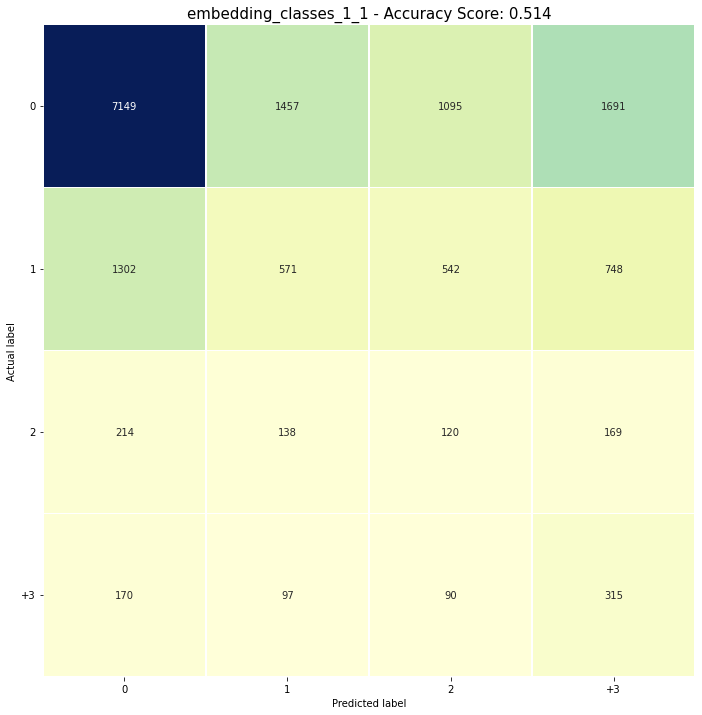

In [48]:
plt_confusion_matrix(saved_for_plot_emb[0], wv_X_dev, develop_class_clean, saved_for_plot_emb[1], f"embedding_classes_{saved_for_plot_emb[2]}_{saved_for_plot_emb[3]}")

# Embeddings Discreto


Probamos embeddings con las clases de los naturales hasta el 20

In [49]:
def get_tweets_class_discrete_emb(dataframe):
  tweets_class = []
  for idx,data in dataframe.iterrows():
      if (isinstance(data['full_text'], float)): continue
      class_tw = 0
      n_ans = data["ans"]
      if n_ans>=int(20):class_tw=20
      else:class_tw = n_ans
      tweets_class.append(class_tw)
  return tweets_class

In [50]:
def get_LogisticRegr_subset_embeddings_discrete(idx_0, idx_1, training_0_df=training_0_df, training_1_df=training_1_df, training_extra_df=training_extra_df):
  training_dataframe = join_dataframes(training_0_df, training_1_df, training_extra_df, idx_0, idx_1)

  training_class = get_tweets_class_discrete_emb(training_dataframe)

  wv_X = get_vectors_matrix(training_dataframe, f"data_embeddings/data_tweets_emb_discrete_{idx_0}_{idx_1}")

  logisticRegr = train_logistic_regression(wv_X, training_class)
  return logisticRegr

In [51]:
develop_class_clean_discrete = get_tweets_class_discrete_emb(develop_df)


Nuevamente tomas el 1er subgrupo de la clase del 1 para ahorrar tiempo de ejecucion

In [52]:
scores = []
idx_0_random = randint(1,18)
idx_1 = 1
for idx_0 in range(1,19):
  logisticRegr = get_LogisticRegr_subset_embeddings_discrete(idx_0, idx_1)
  score = logisticRegr.score(wv_X_dev, develop_class_clean_discrete)
  scores.append(score)
  if idx_0_random == idx_0:
    saved_for_plot_emb = (logisticRegr, score, idx_0, idx_1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------------------
a lo mejor hace falta un delete (del) de los valores de aca arriba, pero hacerlo cuando termina la seccion

In [53]:
print(scores)

[0.5604991177211999]


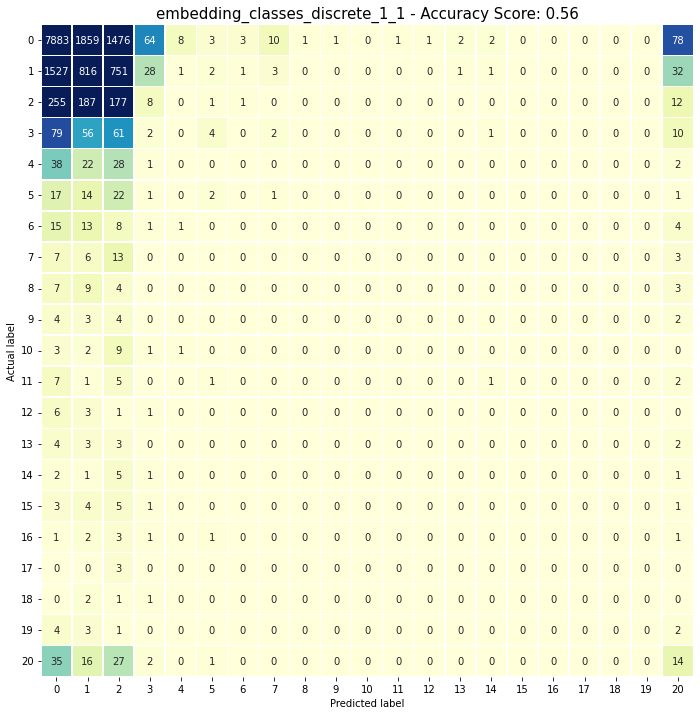

In [54]:
discrete_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt_confusion_matrix(saved_for_plot_emb[0], wv_X_dev, develop_class_clean_discrete, saved_for_plot_emb[1], f"embedding_classes_discrete_{saved_for_plot_emb[2]}_{saved_for_plot_emb[3]}", classes=discrete_classes)

In [55]:
class_1_emb_dis = [0.560436097806907, 0.5583564406352407, 0.5688177464078649, 0.564154272750189, 0.561948575749937, 0.5666750693219057, 0.5564658432064532, 0.5531257877489286, 0.5606251575497857, 0.5731661204940761, 0.5662969498361482, 0.5613183766070078, 0.5651625913788757, 0.5654146710360474, 0.5536929669775649, 0.5604991177211999, 0.5714015628938744, 0.5691958658936224]
class_2_emb_dis = [0.5497227123771111, 0.5493445928913536, 0.5790269725233174, 0.5497227123771111, 0.5550163851777161, 0.554323166120494, 0.5587345601209982, 0.5405218048903454, 0.5587975800352911, 0.5632719939500882, 0.549785732291404, 0.5518023695487774, 0.5557726241492311, 0.5607511973783715, 0.5560877237206957, 0.5622636753214015, 0.5669901688933703, 0.5561507436349886]
class_3_emb_dis = [0.5562137635492815, 0.544492059490799, 0.5424124023191328, 0.5461935971767078, 0.5465717166624653, 0.5501638517771615, 0.554323166120494, 0.5316990168893371, 0.5485883539198386, 0.556591883035039, 0.5541971262919082, 0.5330854550037812, 0.5410259642046887, 0.5599949584068565, 0.5562137635492815, 0.5644063524073607, 0.5563398033778674, 0.5484623140912528]
class_4_emb_dis = [0.5270355432316612, 0.5386942273758508, 0.5511721704058482, 0.5628308545500378, 0.5564028232921603, 0.5578522813208974, 0.5624527350642803, 0.5453743382908999, 0.5521804890345349, 0.5608142172926645, 0.561948575749937, 0.5341567935467608, 0.5593017393496345, 0.5608772372069574, 0.5584194605495336, 0.5535039072346861, 0.5589866397781699, 0.5530627678346357]
class_5_emb_dis = [0.5480841946054953, 0.5579783211494832, 0.5424124023191328, 0.550604991177212, 0.5548273254348374, 0.5511091504915553, 0.5587975800352911, 0.5424754222334257, 0.5657927905218049, 0.5705192840937736, 0.567179228636249, 0.5562767834635745, 0.5561507436349886, 0.5644693723216536, 0.5586715402067053, 0.5593647592639274, 0.5693219057222082, 0.559616838921099]

class_emb_dis = class_1_emb_dis+class_2_emb_dis+class_3_emb_dis+class_4_emb_dis+class_5_emb_dis

In [56]:
from statistics import pstdev
print("promedio:           " ,sum(class_emb_dis)/len(class_emb_dis))
print("desviacion estandar:" ,pstdev(class_emb_dis))

promedio:            0.5559392768114724
desviacion estandar: 0.009397503619810808


# Boxplots

Por ultimo, mostramos con un grafico Boxplot los promedios de los resultados.

In [57]:
methods_list_bow = ["BOW"]*90
percentage_bow = list(zip(classes_perc_bow, methods_list_bow))

methods_list_bow_disc = ["BOW discrete"]*90
percentage_bow_disc = list(zip(classes_perc_bow_disc, methods_list_bow_disc))

methods_list_emb = ["Embeddigns"]*90
percentage_emb = list(zip(classes_perc_emb, methods_list_emb))

methods_list_emb_disc = ["Embeddigns discrete"]*90
percentage_emb_disc = list(zip(class_emb_dis, methods_list_emb_disc))

data_plotbox = percentage_bow + percentage_bow_disc + percentage_emb + percentage_emb_disc
plotbox_dataframe = pd.DataFrame(data_plotbox,columns=["Percentage","Method"])

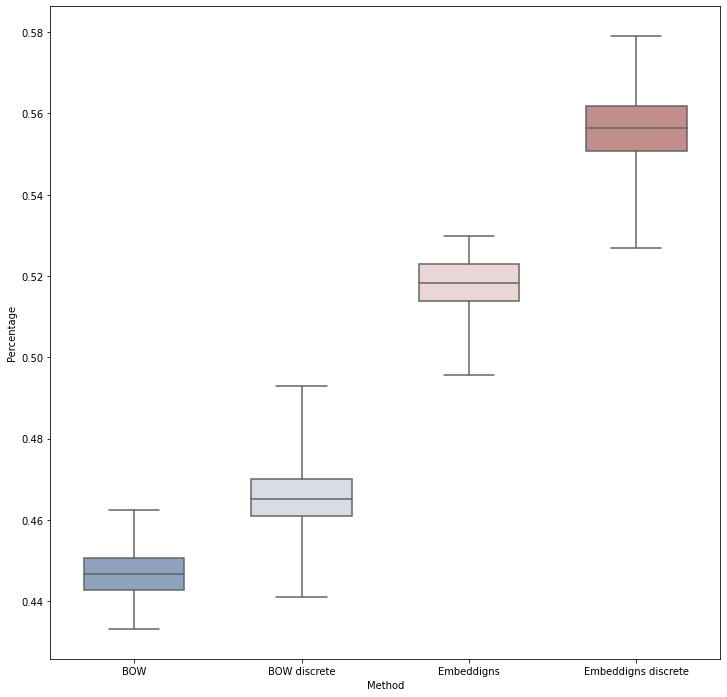

In [58]:
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
fig, ax = plt.subplots(figsize=(12,12))

#https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot

sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(ax=ax, x="Method", y="Percentage",data=plotbox_dataframe,
            whis=[0, 100], width=.6, palette="vlag")

#Ejemplos ELIMINAR

In [59]:
#predecir para valores individuales:
#3, 22 y 86 tuits poco argumentativos (0)
#6, 43 tuits con alguna estructura o argumento (1 o 2-3)
#1636 y 6054 171 9054 15444 15706 tuits con la actualizacion de la informacion(4+)
# examples_idx = [3, 22, 86, 6, 43, 171, 1634, 6052, 9054, 15444, 15706]
# examples_text = []
# examples_real_tag = []
# examples_predicted_tag = []
# for i in examples_idx:
#   examples_text.append(develop_array[i])
#   examples_real_tag.append(develop_class[i])
#   examples_predicted_tag.append(logisticRegr.predict(vectors_develop_df[i:i+1])[0])

In [60]:
# i=0
# for tag in examples_real_tag:
#   if tag == "20+":
#     print(i)
#     print(f'Ejemplo {i}:\n Tag real:     {examples_real_tag[i]}\n Tag obtenida: {examples_predicted_tag[i]}\n Texto del tuit: \n{examples_text[i]}')
#   i+=1

In [61]:
# print(examples_text)
# print(examples_real_tag)
# print(examples_predicted_tag)

# j = 0
# for j in range(len(examples_real_tag)):
#   print("+"*80)
#   print(f'Ejemplo {j}:\n Tag real:     {examples_real_tag[j]}\n Tag obtenida: {examples_predicted_tag[j]}\n Texto del tuit: \n{examples_text[j]}')